In [1]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import datetime

ERROR 1: PROJ: proj_create_from_database: Open of /N/u/gongg/Quartz/anaconda3/envs/gongg/share/proj failed


In [3]:
US = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')
regions_dict = {
    'NE': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV'],
    'Midwest': ['IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH'],
    'SE': ['AL', 'FL', 'GA', 'NC', 'SC', 'VA', 'TN', 'KY', 'AR', 'LA', 'MS'],
    'NGP': ['MT', 'NE', 'ND', 'SD', 'WY'],
    'SGP': ['KS', 'OK', 'TX'],
    'SW': ['AZ', 'CO', 'NM', 'UT', 'CA', 'NV'],
    'NW': ['ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}

In [6]:
import geopandas as gpd
import pandas as pd

# 假设 regions 是一个字典，每个值都是一个 GeoDataFrame（各区域的地理数据）
# 先将所有区域合并为一个 GeoDataFrame
combined_regions = gpd.GeoDataFrame(pd.concat(list(regions.values()), ignore_index=True))

# 确保合并后的 GeoDataFrame 的坐标系是 WGS84
if combined_regions.crs != "EPSG:4326":
    combined_regions = combined_regions.to_crs("EPSG:4326")

# total_bounds 返回 [minx, miny, maxx, maxy]，即 [最西, 最南, 最东, 最北]
minx, miny, maxx, maxy = combined_regions.total_bounds

print("整个区域的边界:")
print(f"  最西 (min lon): {minx:.4f}")
print(f"  最南 (min lat): {miny:.4f}")
print(f"  最东 (max lon): {maxx:.4f}")
print(f"  最北 (max lat): {maxy:.4f}")


整个区域的边界:
  最西 (min lon): -124.8490
  最南 (min lat): 24.3963
  最东 (max lon): -66.8854
  最北 (max lat): 49.3845


### ERA boundry extract

In [10]:
gdf = gpd.read_file('/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp')

In [11]:
ds_era =xr.open_dataset('/N/project/Zli_lab/amulla/JJA/ERA5_land_data_recalculated/Hourly_Total_Precipitation_T_062022.nc')

In [12]:
lon_1d = ds_era.longitude.values
lat_1d = ds_era.latitude.values

lon2d, lat2d = np.meshgrid(lon_1d, lat_1d)

ds_era = ds_era.assign_coords({
    "lon": (("latitude", "longitude"), lon2d),
    "lat": (("latitude", "longitude"), lat2d)
}).drop_vars(["latitude", "longitude"])

In [13]:
import xarray as xr
import geopandas as gpd
import numpy as np

from shapely.geometry import Point

gdf = gpd.read_file("/N/project/Zli_lab/Data/Other/tl_2019_us_state/tl_2019_us_state.shp")

# === 2. 提取 2D 经纬度数组 ===
lat = ds_era['lat'].values
lon = ds_era['lon'].values

# === 3. 创建 GeoDataFrame 的网格点 ===
grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()),
    index=np.arange(lon.size)
)
grid.set_crs(gdf.crs, inplace=True)  # 设置投影为 shapefile 的 CRS

# === 4. 使用空间连接（spatial join）保留落在 shapefile 内的点 ===
grid_s = gpd.sjoin(grid, gdf, how='inner', predicate='within')

# === 5. 创建布尔 mask，并 reshape 回 2D ===
mask_flat = np.zeros(lon.size, dtype=bool)
mask_flat[grid_s.index.values] = True
mask_2d = mask_flat.reshape(lat.shape)

# === 6. 应用掩码到 ERA 数据 ===
ds_era_masked = ds_era.where(mask_2d)

# === 7. 可选：保存为 NetCDF ===
# ds_era_masked.to_netcdf("ds_era_masked.nc")

# === 8. 可视化测试 ===
# ds_era_masked.tp.mean('time').plot(x='lon', y='lat')


In [34]:
import xarray as xr
import numpy as np

# Step 1: 提取原始 2D lat/lon
lat2d = ds_era_masked['lat'].values
lon2d = ds_era_masked['lon'].values

# Step 2: 假设网格是规则的，从2D中提取一维
lat_1d = np.unique(lat2d[:, 0])  # 所有行的第一个值是纬度
lon_1d = np.unique(lon2d[0, :])  # 第一行的所有值是经度

# Step 3: 将变量插入新坐标中（这里以 tp 为例）
ds_era_1d = xr.Dataset(
    {
        'tp': (('time', 'lat', 'lon'), ds_era_masked['tp'].values)
    },
    coords={
        'time': ds_era_masked['time'],
        'lat': lat_1d[::-1],
        'lon': lon_1d
    }
)


In [49]:
ds_era_cropped = ds_era_1d.sel(
    lon=slice(-124.8490, -66.8854),
    lat=slice(49.3845, 24.396)  # 注意 lat 是降序
)

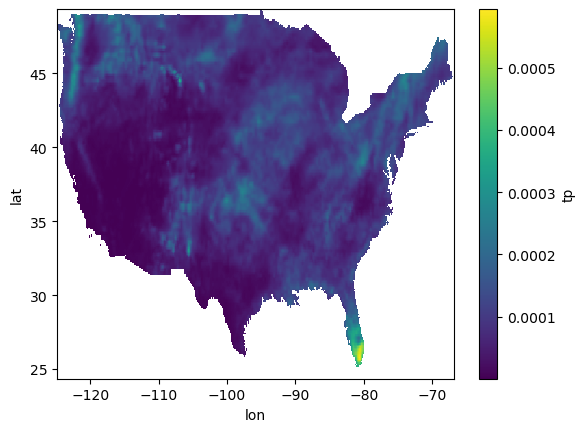

In [55]:
ds_era_cropped.mean('time').tp.plot()
plt.show()

In [57]:
ds_era_cropped.to_netcdf('ref_.1deg.nc')